In [2]:
import pathlib
import matplotlib.pyplot as plt

data_dir = pathlib.Path('chest_xray')

train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [3]:
print(list(train_dir.glob('*')))
print(list(val_dir.glob('*')))
print(list(test_dir.glob('*')))

[WindowsPath('chest_xray/train/NORMAL'), WindowsPath('chest_xray/train/PNEUMONIA')]
[WindowsPath('chest_xray/val/NORMAL'), WindowsPath('chest_xray/val/PNEUMONIA')]
[WindowsPath('chest_xray/test/NORMAL'), WindowsPath('chest_xray/test/PNEUMONIA')]


In [4]:
normal_train = train_dir / 'NORMAL'
pneumonia_train = train_dir / 'PNEUMONIA'

print(f'Total training NORMAL images: {len(list(normal_train.glob("*.jpeg")))}')
print(f'Total training PNEUMONIA images: {len(list(pneumonia_train.glob("*.jpeg")))}')

Total training NORMAL images: 1341
Total training PNEUMONIA images: 3875


In [5]:
normal_images = list(normal_train.glob('*.jpeg'))
pneumonia_images = list(pneumonia_train.glob('*.jpeg'))

print(f'Sample NORMAL image path: {normal_images[0]}')
print(f'Sample PNEUMONIA image path: {pneumonia_images[0]}')


Sample NORMAL image path: chest_xray\train\NORMAL\IM-0115-0001.jpeg
Sample PNEUMONIA image path: chest_xray\train\PNEUMONIA\person1000_bacteria_2931.jpeg


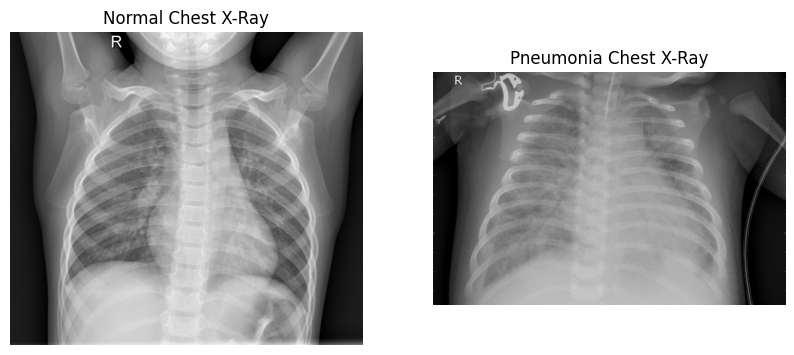

In [6]:
normal_img = plt.imread(normal_images[0])
pneumonia_img = plt.imread(pneumonia_images[0])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(normal_img, cmap='gray')
axes[0].set_title('Normal Chest X-Ray')
axes[0].axis('off')

axes[1].imshow(pneumonia_img, cmap='gray')
axes[1].set_title('Pneumonia Chest X-Ray')  
axes[1].axis('off')

plt.show()

In [7]:
import tensorflow as tf

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [9]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42
)

Found 624 files belonging to 2 classes.


In [10]:
val_size = int(len(train_ds) * 0.2)
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

print(f'Training batches: {len(train_ds)}')
print(f'Validation batches: {len(val_ds)}')

Training batches: 131
Validation batches: 32


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [17]:

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [20]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

In [21]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 567ms/step - accuracy: 0.8865 - loss: 0.2568 - precision: 0.9187 - recall: 0.9304 - val_accuracy: 0.9131 - val_loss: 0.2130 - val_precision: 0.9689 - val_recall: 0.9109
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 45s 341ms/step - accuracy: 0.9184 - loss: 0.1919 - precision: 0.9460 - recall: 0.9448 - val_accuracy: 0.9121 - val_loss: 0.2179 - val_precision: 0.9783 - val_recall: 0.9003
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 332ms/step - accuracy: 0.9292 - loss: 0.1714 - precision: 0.9545 - recall: 0.9505 - val_accuracy: 0.9131 - val_loss: 0.2085 - val_precision: 0.9770 - val_recall: 0.9029
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 332ms/step - accuracy: 0.9337 - loss: 0.1587 - precision: 0.9568 - recall: 0.9544 - val_accuracy: 0.9170 - val_loss: 0.2037 - val_precision: 0.9771 - val_recall: 0.9082
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 44s 334ms/step - accuracy: 0.9377 - loss: 0.1488 - precision: 0.9588 - recall: 0.9579 - val_accuracy: 0.9199

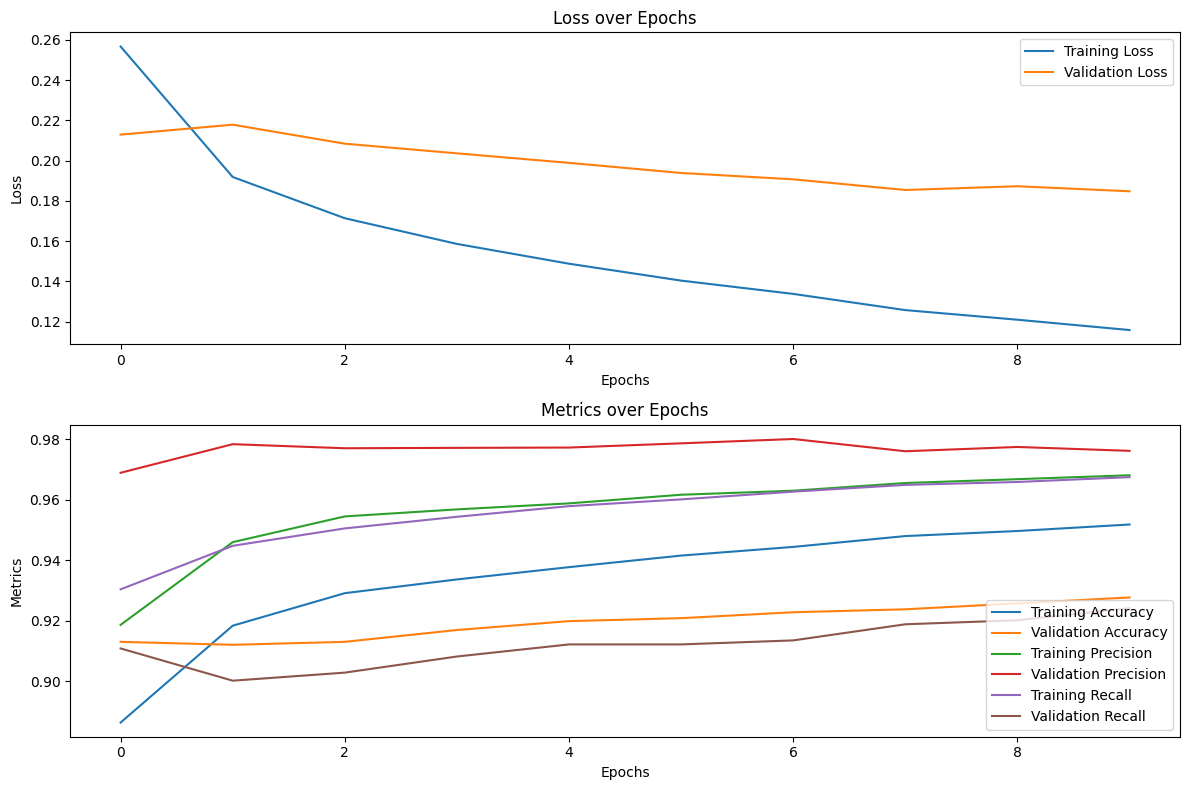

In [22]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss'),
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')  
plt.legend()    


plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')  
plt.title('Metrics over Epochs')
plt.xlabel('Epochs')        
plt.ylabel('Metrics')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
results = model.evaluate(test_ds)
for name, value in zip(model.metrics_names, results):
    print(f'{name}: {value:.4f}\n')

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - accuracy: 0.8462 - loss: 0.4259 - precision: 0.8267 - recall: 0.9538
loss: 0.4259

compile_metrics: 0.8462



In [26]:
model.save('pneumonia_model.keras')

print("Model saved successfully!")

Model saved successfully!
